<a href="https://colab.research.google.com/github/1stPtrp/BigData_project/blob/master/Project_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disaster tweets Classification

---



*   Predicting whether a given tweet is about a real disaster or not. [Data 
from Kaggle]
*   Process flow brief : EDA, Cleansing(hastag, URL and so on),  Tokenization, Sequencing, Word Embedding, TrainTest, Deep learning Model
*   Evaluation : F1 Score



Task 1: Import Packages and Functions

---



In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
import re
print(tf.__version__)

2.3.0


Task 2: Load and Explore Data

---



In [47]:
!wget -O train.csv https://raw.githubusercontent.com/1stPtrp/BigData_project/master/train.csv

!wget -O test.csv https://raw.githubusercontent.com/1stPtrp/BigData_project/master/test.csv

--2020-11-07 10:59:59--  https://raw.githubusercontent.com/1stPtrp/BigData_project/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.1s    

2020-11-07 11:00:00 (7.52 MB/s) - ‘train.csv’ saved [987712/987712]

--2020-11-07 11:00:00--  https://raw.githubusercontent.com/1stPtrp/BigData_project/master/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420783 (411K) [text/plain]
Saving to: ‘test.csv’



In [48]:
# Load Data
filePath = "/content/train.csv"
train_df = pd.read_csv(filePath).fillna(' ')
train_df.sample(10, random_state=1)

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1
2539,3643,desolation,Istanbul,#np agalloch - the desolation song,0
6837,9794,trapped,,Hollywood Movie About Trapped Miners Released ...,1
7386,10570,windstorm,Houston,New roof and hardy up..Windstorm inspection to...,0
1506,2174,catastrophic,Inexpressible Island,The Catastrophic Effects of Hiroshima and Naga...,1
1875,2694,crush,Everywhere,tiffanyfrizzell has a crush: http://t.co/RaF73...,0


In [49]:
x = train_df['text'].values
print(x[109:112])

["'The harder the conflict the more glorious the triumph.' Thomas Paine"
 "#GrowingUpSpoiled going clay pigeon shooting and crying because of the 'aftershock'"
 'So i guess no one actually wants any free Aftershock TC.....']


In [50]:
# View few text
train_df.loc[train_df['target']==1].sample(10, random_state=10)

,id,keyword,location,text,target
7239,10367,weapons,West,WWII Memories Plus Lessons of Hiroshima We Sti...,1
5789,8259,rioting,trapped in America,@evacide The Ferguson RIOTS worked. This of th...,1
3987,5664,floods,Australia,In #India 119000 people have taken shelter in ...,1
2184,3131,debris,,Aircraft debris found on island is from MH370 ...,1
5905,8433,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1
300,442,apocalypse,,Shadow boxing the apocalypse,1
5694,8126,rescued,Earth,Migrants Rescued After Boat Capsizes Off Libya...,1
3112,4466,electrocuted,North Carolina,I'm loving this classic barn shot! We may or m...,1
863,1245,blood,,Can't believe more people in their mid 20's do...,1
5092,7264,nuclear%20disaster,"Ashford, Kent, United Kingdom",@emmerdale can we have a public vote for the n...,1


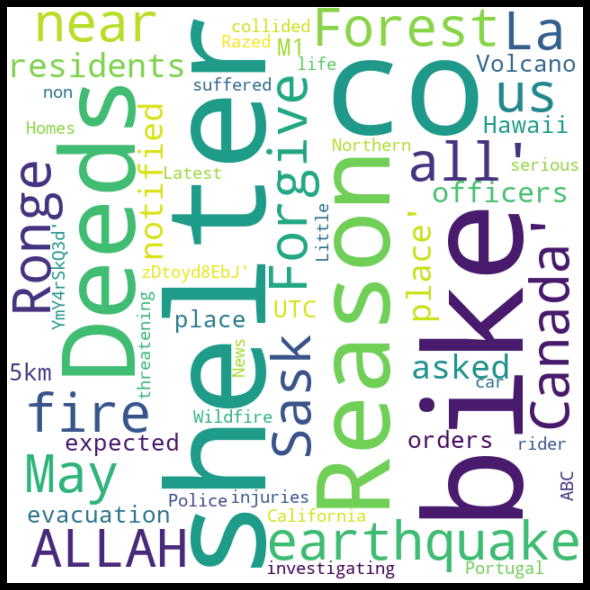

In [51]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
texts = train_df['text'].loc[train_df['target']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(texts))
fig = plt.figure(
    figsize =(12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

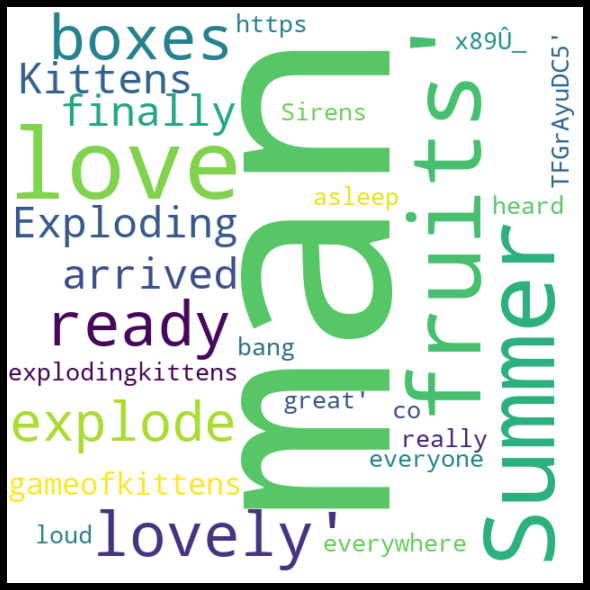

In [52]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
texts = train_df['text'].loc[train_df['target']==0].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(texts))
fig = plt.figure(
    figsize =(12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [53]:
y = train_df['target'].values
print(y)

[1 1 1 ... 1 1 1]


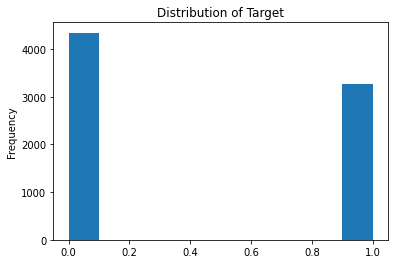

In [54]:
# Plot Frequency of target
train_df['target'].plot(kind='hist', title='Distribution of Target')

In [55]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Task 3: Data Prep -- Tokenize and Pad Text Data

---



In [56]:
puncts = [
    ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '¬', '░', '¶', '↑', '±',  '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '₹', '´','/','#'
]

In [57]:
%%time
def clean_punct(x):
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x
train_df["text"] = train_df["text"].apply(lambda x: clean_punct(x))

CPU times: user 63.8 ms, sys: 2.97 ms, total: 66.8 ms
Wall time: 70.3 ms


In [58]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [59]:
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [60]:
train_df["text"] = train_df["text"].apply(lambda x: remove_URL(x))
train_df["text"] = train_df["text"].apply(lambda x: remove_emoji(x))
train_df["text"] = train_df["text"].apply(lambda x: remove_html(x))
train_df["text"] = train_df["text"].apply(lambda x : remove_punct(x))

In [61]:
x = train_df['text'].values
print(x[109:112])

['  The harder the conflict the more glorious the triumph     Thomas Paine'
 '    GrowingUpSpoiled going clay pigeon shooting and crying because of the   aftershock  '
 'So i guess no one actually wants any free Aftershock TC          ']


In [62]:
max_features = 20000
max_text_length = 400

In [63]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

---



In [64]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [65]:
embedding_dim = 300
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [66]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
      break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

Task 5:Create the Embedding Layer

---



In [67]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                    embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

Task 6: Build the Model

---



In [68]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [69]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 250)         225250    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)              

In [70]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Task 7: Train Model

---



In [71]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y,
                                                  test_size=0.15, random_state=1)

In [72]:
%%time
batch_size = 32
epochs = 100

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data= (x_val, y_val))

Epoch 1/100
203/203 [==============================] - 111s 545ms/step - loss: 0.4780 - accuracy: 0.7820 - val_loss: 0.4427 - val_accuracy: 0.8065
Epoch 2/100
203/203 [==============================] - 111s 546ms/step - loss: 0.4068 - accuracy: 0.8271 - val_loss: 0.4433 - val_accuracy: 0.8082
Epoch 3/100
203/203 [==============================] - 110s 540ms/step - loss: 0.3571 - accuracy: 0.8444 - val_loss: 0.4703 - val_accuracy: 0.8196
Epoch 4/100
203/203 [==============================] - 110s 541ms/step - loss: 0.3050 - accuracy: 0.8742 - val_loss: 0.4886 - val_accuracy: 0.8109
Epoch 5/100
203/203 [==============================] - 109s 538ms/step - loss: 0.2408 - accuracy: 0.9081 - val_loss: 0.5518 - val_accuracy: 0.8135
Epoch 6/100
203/203 [==============================] - 109s 539ms/step - loss: 0.1802 - accuracy: 0.9312 - val_loss: 0.6332 - val_accuracy: 0.7697
Epoch 7/100
203/203 [==============================] - 112s 550ms/step - loss: 0.1367 - accuracy: 0.9493 - val_loss: 0

Task 8:Evaluate Model

---



In [73]:
val_predictions = model.predict(x_val, verbose=1, batch_size=32)

36/36 [==============================] - 6s 172ms/step


In [74]:
val_predictions.shape

(1142, 1)

In [75]:
val_predictions

array([[4.8109272e-05],
       [2.5009155e-02],
       [2.5334220e-06],
       ...,
       [1.9970536e-04],
       [1.0000000e+00],
       [6.6249281e-02]], dtype=float32)

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_val,val_predictions_int))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       656
           1       0.87      0.65      0.74       486

    accuracy                           0.81      1142
   macro avg       0.82      0.79      0.79      1142
weighted avg       0.82      0.81      0.80      1142



In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val,val_predictions_int)

array([[608,  48],
       [172, 314]])

In [78]:
from sklearn import metrics
import seaborn as sns

val_predictions_int = val_predictions.round().astype('int')

In [79]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

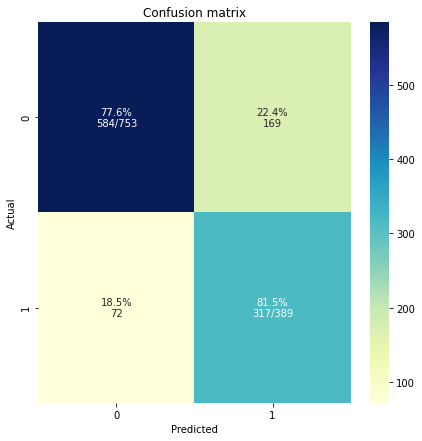

In [80]:
from sklearn.metrics import classification_report,confusion_matrix
# Showing Confusion Matrix
plot_cm(val_predictions_int, y_val, 'Confusion matrix', figsize=(7,7))

In [81]:
#Import Test dataset
test_df = pd.read_csv('/content/test.csv')

In [82]:
test_df.shape

(3263, 4)

In [83]:
test_df["text"] = test_df["text"].apply(lambda x: clean_punct(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_URL(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_emoji(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_html(x))
test_df["text"] = test_df["text"].apply(lambda x : remove_punct(x))

In [84]:
x_test = test_df['text'].values

In [85]:
def predict_writesub(x_test):
    x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
    x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)
    predictions = model.predict(x_testing, verbose=1, batch_size=32)
    submission = pd.DataFrame({'id': test_df['id'], 'target': predictions.ravel()})
    submission['target'] = np.where(submission['target']  > 0.5, 1, 0)
    submission.to_csv('submit.csv', index = False)
    print(submission.head())
    
predict_writesub(x_test)

102/102 [==============================] - 19s 183ms/step
   id  target
0   0       0
1   2       1
2   3       1
3   9       1
4  11       1


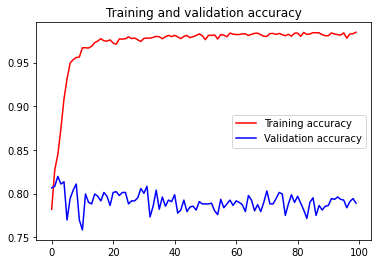

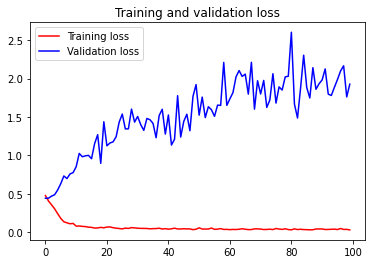

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()